In [1]:
!pip install -q -U watermark

In [2]:
!pip install -qq transformers==3.1.0

     |████████████████████████████████| 884 kB 5.3 MB/s 
     |████████████████████████████████| 895 kB 27.4 MB/s 
     |████████████████████████████████| 1.2 MB 16.3 MB/s 
     |████████████████████████████████| 3.0 MB 17.6 MB/s 


In [3]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

numpy       : 1.21.5
pandas      : 1.3.5
torch       : 1.10.0+cu111
transformers: 3.1.0



In [4]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from tqdm import tqdm
import csv

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Configuration values for plotting
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Seeding and more config
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# GLOBAL VARIABLES
stance_map = {'agree': 0, 'disagree':1, 'discuss':2, 'unrelated':3}
stance_map_inv = {0: 'agree', 1:'disagree', 2:'discuss', 3: 'unrelated'}
MAX_LENGTH = 160
BATCH_SIZE = 16
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
EPOCHS = 2

In [6]:
def get_body_dict(data_dir):
    with open(data_dir, encoding='utf_8') as tb:
        body_text = list(csv.reader(tb))
        body_text_dict = {}
        for i, line in enumerate(tqdm(body_text)):
            if i > 0:
                id = int(line[0])
                body_text_dict[id] = line[1]
    return body_text_dict

In [7]:
def get_article_data(data_dir, body_text_dict):
    with open(data_dir, encoding='utf_8') as ts:
        stances_text = list(csv.reader(ts))

        headlines, bodies, stances = [], [], []

        for i, line in enumerate(tqdm(stances_text)):
            if i > 0:
                body_id = int(line[1].strip())

                stances.append(line[2].strip())
                headlines.append(line[0].strip())
                bodies.append(body_text_dict[body_id])
        return stances, headlines, bodies

In [8]:
# Initialize data directory and read in data
data_dir = "data"
train_stances_path = data_dir + "/train_stances.csv"
train_body_path = data_dir + "/train_bodies.csv"

train_bodies_dict = get_body_dict(train_body_path)
s, h, b = get_article_data(train_stances_path, train_bodies_dict)

100%|██████████| 49973/49973 [00:00<00:00, 267970.48it/s]


In [10]:
# Create data frame for training
data_df = pd.DataFrame(list(zip(h, b, s)), columns=['h', 'b', 's'])

data_df['hb'] = data_df['h'] + '[SEP]' + data_df['b']
data_df['s_int'] = data_df.apply(lambda row: stance_map.get(row['s']), axis=1)
data_df.head()

,h,b,s,hb,s_int
0,Police find mass graves with at least '15 bodi...,Danny Boyle is directing the untitled film\n\n...,unrelated,Police find mass graves with at least '15 bodi...,3
1,Hundreds of Palestinians flee floods in Gaza a...,Hundreds of Palestinians were evacuated from t...,agree,Hundreds of Palestinians flee floods in Gaza a...,0
2,"Christian Bale passes on role of Steve Jobs, a...",30-year-old Moscow resident was hospitalized w...,unrelated,"Christian Bale passes on role of Steve Jobs, a...",3
3,HBO and Apple in Talks for $15/Month Apple TV ...,(Reuters) - A Canadian soldier was shot at the...,unrelated,HBO and Apple in Talks for $15/Month Apple TV ...,3
4,Spider burrowed through tourist's stomach and ...,"Fear not arachnophobes, the story of Bunbury's...",disagree,Spider burrowed through tourist's stomach and ...,1


In [11]:
# Create tokenizer from BertTokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


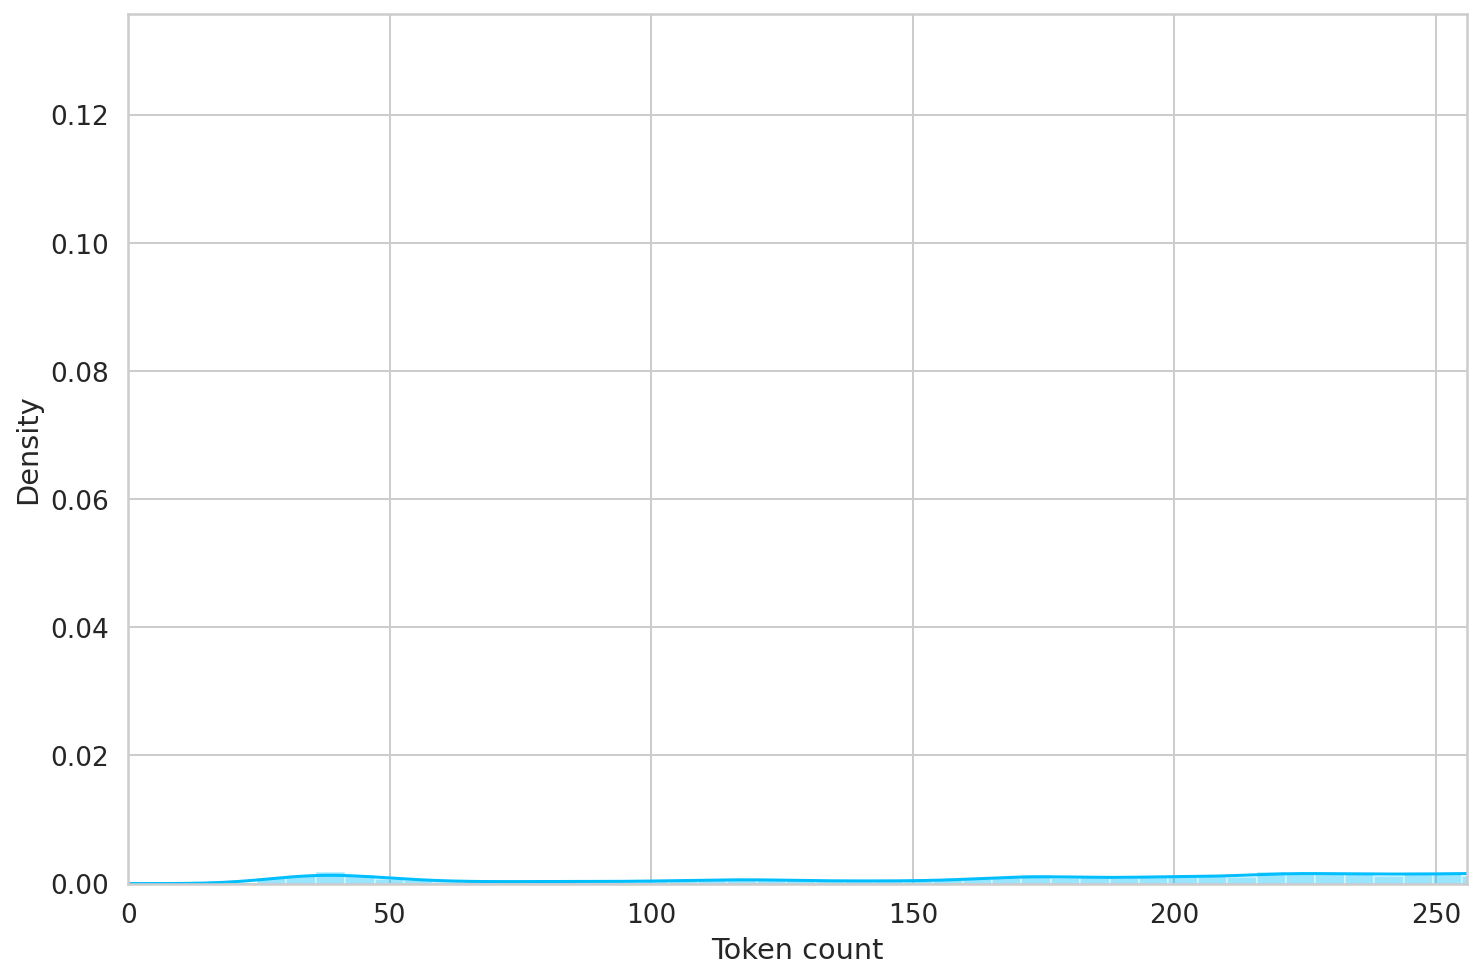

In [12]:
# Determine a logical number for max length by plotting the tokens
token_lens = []

for txt in data_df['hb']:
  tokens = tokenizer.encode(txt, max_length=300, truncation = True)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [13]:
# Create a class that initializes the header body text, stances, tokenizer and max length
# The class creates an encoding for the data using the parameters selected and returns the encoding
class FNCDataSet(Dataset):

  def __init__(self, hb_text, stances, tokenizer, max_len):
    self.hb_text = hb_text
    self.stances = stances
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.hb_text)
  
  def __getitem__(self, item):
    hb_text = str(self.hb_text[item])
    stances = self.stances[item]

    # create encoding
    encoding = self.tokenizer.encode_plus(
      hb_text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation = True
    )

    return {
      'hb_text': hb_text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'stances': torch.tensor(stances, dtype=torch.long)
    }

In [14]:
# Get the training set and validation set using train_test_split
df_train, df_val = train_test_split(data_df, test_size=0.1, random_state=RANDOM_SEED)

In [15]:
# Method to use the FNCDataSet class and get the encodings wrapped in a Data Loader 
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = FNCDataSet(
    hb_text=df['hb'].to_numpy(),
    stances=df['s_int'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [16]:
# Instatiate training data loader and validation data loader
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LENGTH, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LENGTH, BATCH_SIZE)

In [17]:
# Gather data using the training data loader and check sizes if the input ids, attention mask and stances (targets)
data = next(iter(train_data_loader))
data.keys()
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['stances'].shape)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [18]:
# Create a classifier class that instiates the BERT model, tuned dropout rates for regularization and obtain a fully 
# connected layer for the output as well as cross entropy
class NewsClassifier(nn.Module):

  def __init__(self, n_classes):
    super(NewsClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [19]:
# Create an instance of the classifier and use the GPU
model = NewsClassifier(len(stance_map))
model = model.to(device)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [21]:
# Move input ids and attention mask to the gpu as well
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [22]:
# Obtain predicted probabilities from the softmax function
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2966, 0.2858, 0.2557, 0.1619],
        [0.4550, 0.1859, 0.2487, 0.1104],
        [0.3988, 0.1734, 0.2570, 0.1708],
        [0.5284, 0.1071, 0.2098, 0.1547],
        [0.3190, 0.1998, 0.2935, 0.1877],
        [0.2811, 0.4196, 0.1723, 0.1271],
        [0.3496, 0.2222, 0.2391, 0.1891],
        [0.3106, 0.1339, 0.2686, 0.2869],
        [0.3737, 0.1635, 0.2325, 0.2303],
        [0.4664, 0.1783, 0.2530, 0.1023],
        [0.1763, 0.2388, 0.4325, 0.1524],
        [0.3855, 0.2470, 0.2632, 0.1043],
        [0.4362, 0.1385, 0.2996, 0.1256],
        [0.3762, 0.2438, 0.1988, 0.1812],
        [0.4015, 0.1742, 0.3257, 0.0987],
        [0.4873, 0.0953, 0.2827, 0.1347]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

# Training the Model

In [23]:
# Start the training processes using the BERT model and AdamW optimizer from Hugging Face
# using some of the recommended parameters for fine tuning:
# Batch size: 16, 32
# Learning rate (Adam): 5e-5, 3e-5, 2e-5
# Number of epochs: 2, 3, 4

EPOCHS = 2

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

# Linear scheduler
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [24]:
# Method used for training each epoch
# Uses dataloader and saves values to GPU and takes outputs and uses the 
# argmax function to get predictions
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    stances = d["stances"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    # Get predictions and loss
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, stances)

    correct_predictions += torch.sum(preds == stances)
    losses.append(loss.item())

    loss.backward()
    # clip gradients
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [25]:
# Helper method to evalute model using the data loaders
# Returm accuracy by comparing the predictions to the correct stances/targets
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      stances = d["stances"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, stances)

      correct_predictions += torch.sum(preds == stances)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [34]:
%%time

# Run model by taking the history and best accuracy for all epochs and using helper methods
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  # save model
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state2.bin')
    best_accuracy = val_acc

Epoch 1/2
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Train loss 0.2645085674359286 accuracy 0.9105705518744163


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.15454838457972014 accuracy 0.9455782312925171

Epoch 2/2
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.10889180067856645 accuracy 0.9652021167785831


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.1038189141684455 accuracy 0.9711884753901562

CPU times: user 1h 1min 35s, sys: 20min 34s, total: 1h 22min 10s
Wall time: 1h 23min 12s


In [35]:
# Uncomment to read in saved model to gpu

# model = SentimentClassifier(len(stance_map))
# torch.load('best_model_state.bin')
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

In [112]:
# Gather training accuracies and validation accuracies from training set
history['train_acc'][0].item()

train_acc_list = []
for x in history['train_acc']:
  train_acc_list.append(x.item())
train_acc_list

val_acc_list = []
for x in history['val_acc']:
  val_acc_list.append(x.item())
val_acc_list

[0.9455782312925171, 0.9711884753901562]

In [117]:
print(train_acc_list)
print(val_acc_list)

[0.9105705518744163, 0.9652021167785831]
[0.9455782312925171, 0.9711884753901562]


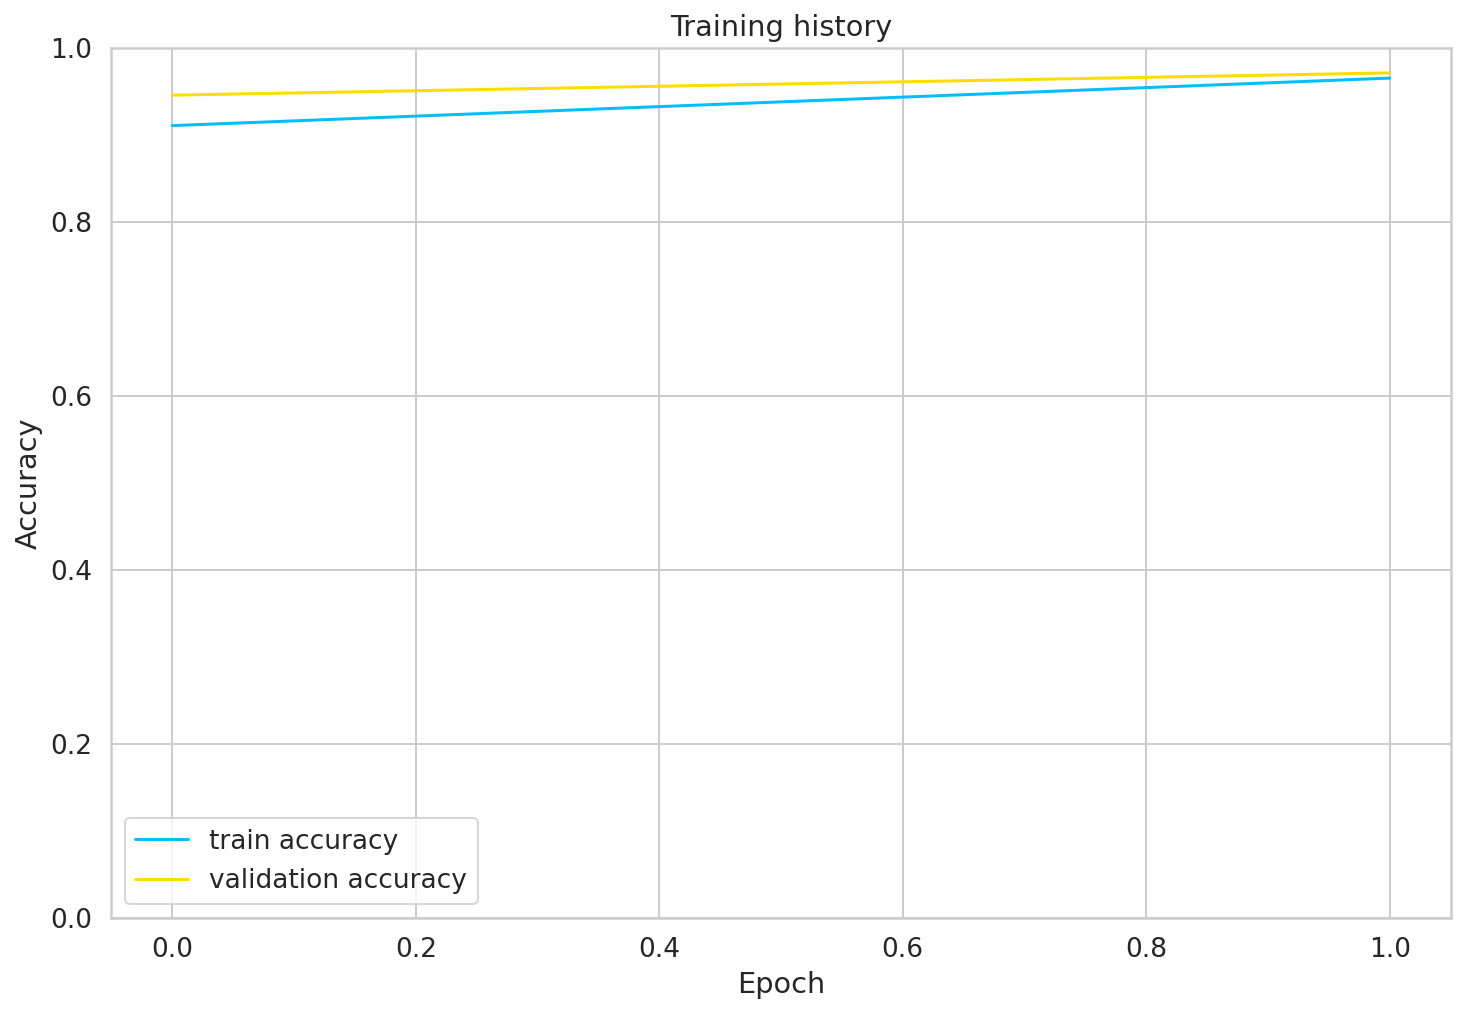

In [120]:
# Plot the training and validation history and accuracies for each epoch
plt.plot(train_acc_list, label='train accuracy')
plt.plot(val_acc_list, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [122]:
# Save model just in case :) 
from google.colab import drive
drive.mount('/content/gdrive')
torch.save(model.state_dict(), '/content/gdrive/MyDrive/fnc/best_model_state2.bin')

Mounted at /content/gdrive


# Run trained model on the test set

In [27]:
# Read in test data (headline, body, stances/targets)
test_stances_path = data_dir + "/competition_test_stances.csv"
test_body_path = data_dir + "/competition_test_bodies.csv"

test_bodies_dict = get_body_dict(test_body_path)
stest, htest, btest = get_article_data(test_stances_path, test_bodies_dict)

list_zip = list(zip(htest, btest, stest))
test_data_df = pd.DataFrame(list(zip(htest, btest, stest)), columns=['h', 'b', 's'])

test_data_df['hb'] = test_data_df['h'] + '[SEP]' + test_data_df['b']
test_data_df['s_int'] = test_data_df.apply(lambda row: stance_map.get(row['s']), axis=1)

test_data_loader = create_data_loader(test_data_df, tokenizer, MAX_LENGTH, BATCH_SIZE)

100%|██████████| 25414/25414 [00:00<00:00, 273295.63it/s]


In [131]:
# Determine accuracy of model on the test data
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(test_data_df)
)

test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

0.8917089678510999

In [132]:
# Helper function to get predictions from model and test data loader
# This function also uses the softmax function for getting probability distributions
def get_predictions(model, data_loader):
  model = model.eval()
  
  hb_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["hb_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      stances = d["stances"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      hb_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(stances)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return hb_texts, predictions, prediction_probs, real_values

In [133]:
# Use the helper function to get probabilities on the test data and return the headline body text
y_hb_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

In [134]:
# Obtain classification report
print(classification_report(y_test, y_pred, target_names=stance_map.keys()))

              precision    recall  f1-score   support

       agree       0.51      0.65      0.57      1903
    disagree       0.32      0.07      0.12       697
     discuss       0.78      0.74      0.76      4464
   unrelated       0.97      0.98      0.98     18349

    accuracy                           0.89     25413
   macro avg       0.65      0.61      0.61     25413
weighted avg       0.89      0.89      0.89     25413



In [221]:
# Create the answer data frame using the unlabeled set and adding the predictions
answer_df = pd.read_csv("competition_test_stances_unlabeled.csv")
answer_df['Stance'] = pd.DataFrame(y_pred.numpy()).apply(lambda row: stance_map_inv.get(row[0]), axis=1)

In [224]:
answer_df.head()

,Headline,Body ID,Stance
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated
4,Argentina's President Adopts Boy to End Werewo...,37,unrelated


In [227]:
# Save answer to mounted google drive
answer_df.to_csv('/content/gdrive/MyDrive/fnc/answer.csv', index=False, encoding='utf-8') # From pandas library

# Visualizations and Curiosity Testing

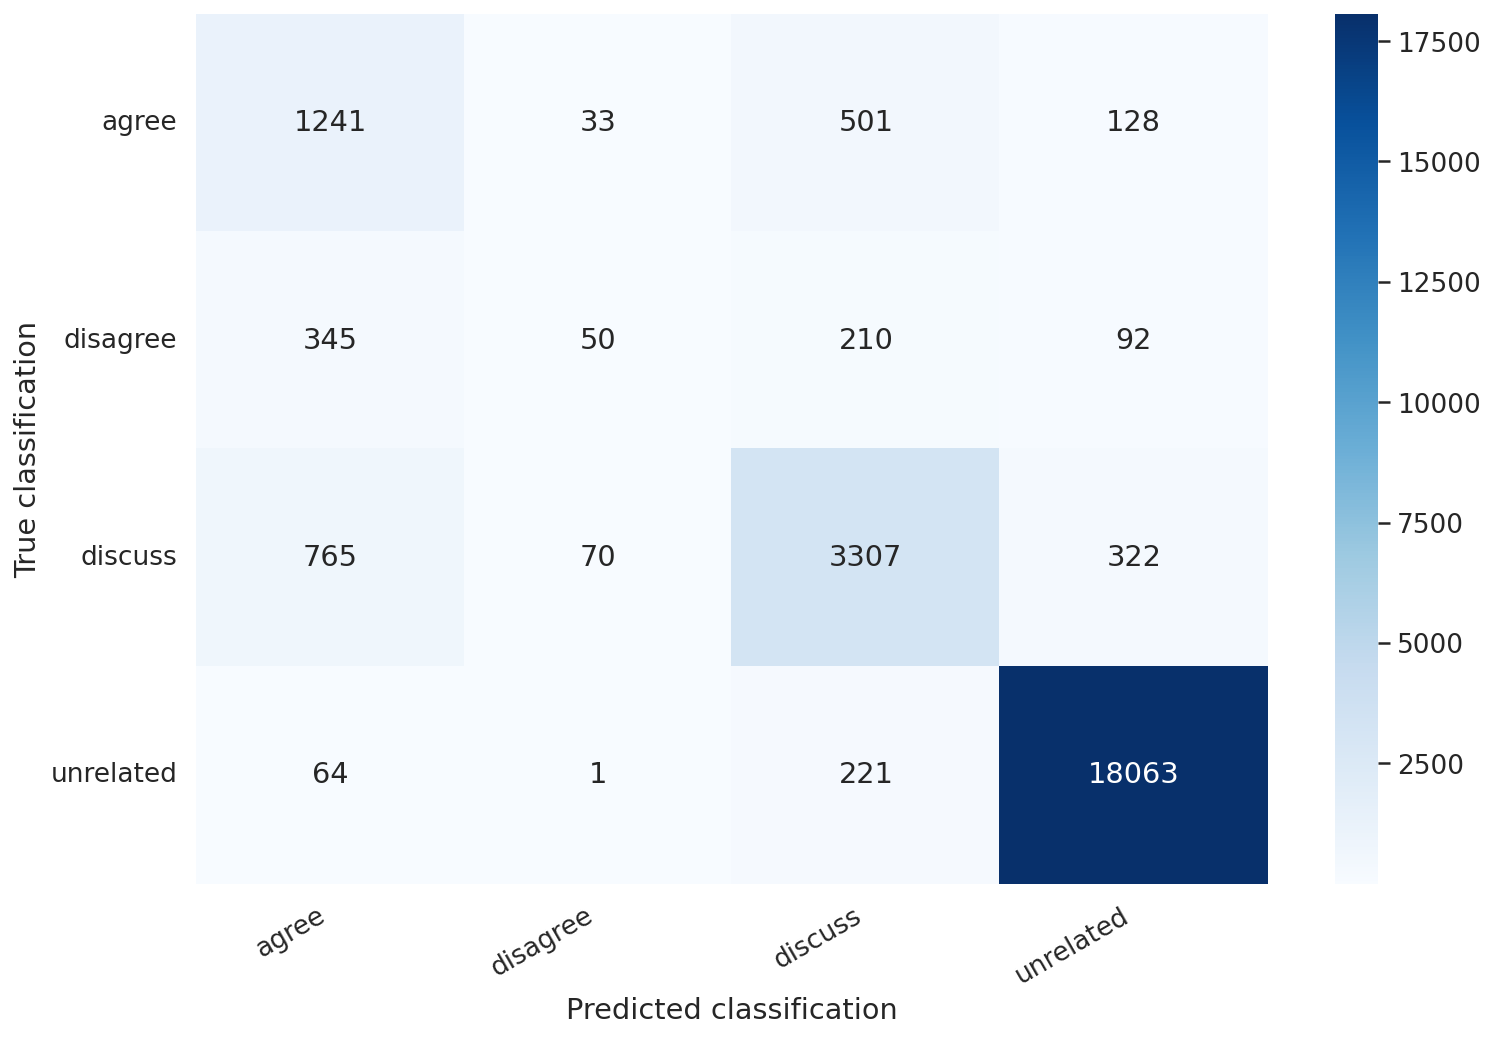

In [135]:
# Helper function to show a heatmap for the confusion matrix using the probabilieis
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True classification')
  plt.xlabel('Predicted classification');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=stance_map.keys(), columns=stance_map.keys())
show_confusion_matrix(df_cm)

In [231]:
# Create some random header and body text and see the outputted classifications
h_text = "It was the warmest day of 2022"
b_text = "Weather officials say you need sunscreen"
hb_text = h_text + "[SEP]" + b_text
encoded_text = tokenizer.encode_plus(
  hb_text,
  max_length=MAX_LENGTH,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Headline Body text: {hb_text}')
print(f'Classification  : {stance_map_inv.get(prediction.item())}')

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Headline Body text: It was the warmest day of 2022[SEP]Weather officials say you need sunscreen
Classification  : agree


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Man saved from bear attack - thanks to his Justin Bieber
ringtone[SEP]Justin Bieber may not have been able to take on Orlando
Bloom, but he sure as hell was able to take on a bear.  No, PETA,
Bieber didn’t beat down a bear, he just scared one away in Russia's
Yakutia Republic.  It all went down when 42-year-old fisherman Igor
Vorozhbitsyn’s attack by a brown bear was interrupted by a Justin
Bieber ringtone.  The fisherman explains:  "I had parked my car and
was walking towards the spot I'd marked out when there was a
tremendous impact on my back and the bear was on top of me." That’s
when Vorozhbitsyn’s phone went off and “Baby” started blaring, causing
the bear to run off.  He also justified his surprising ringtone:  "I
know that sort of ringtone isn't to everyone's taste,” he said, “but
my granddaughter loaded it onto my phone for a joke.”  Living with
embarrassment is a small price to pay for your life.
True classification: agree


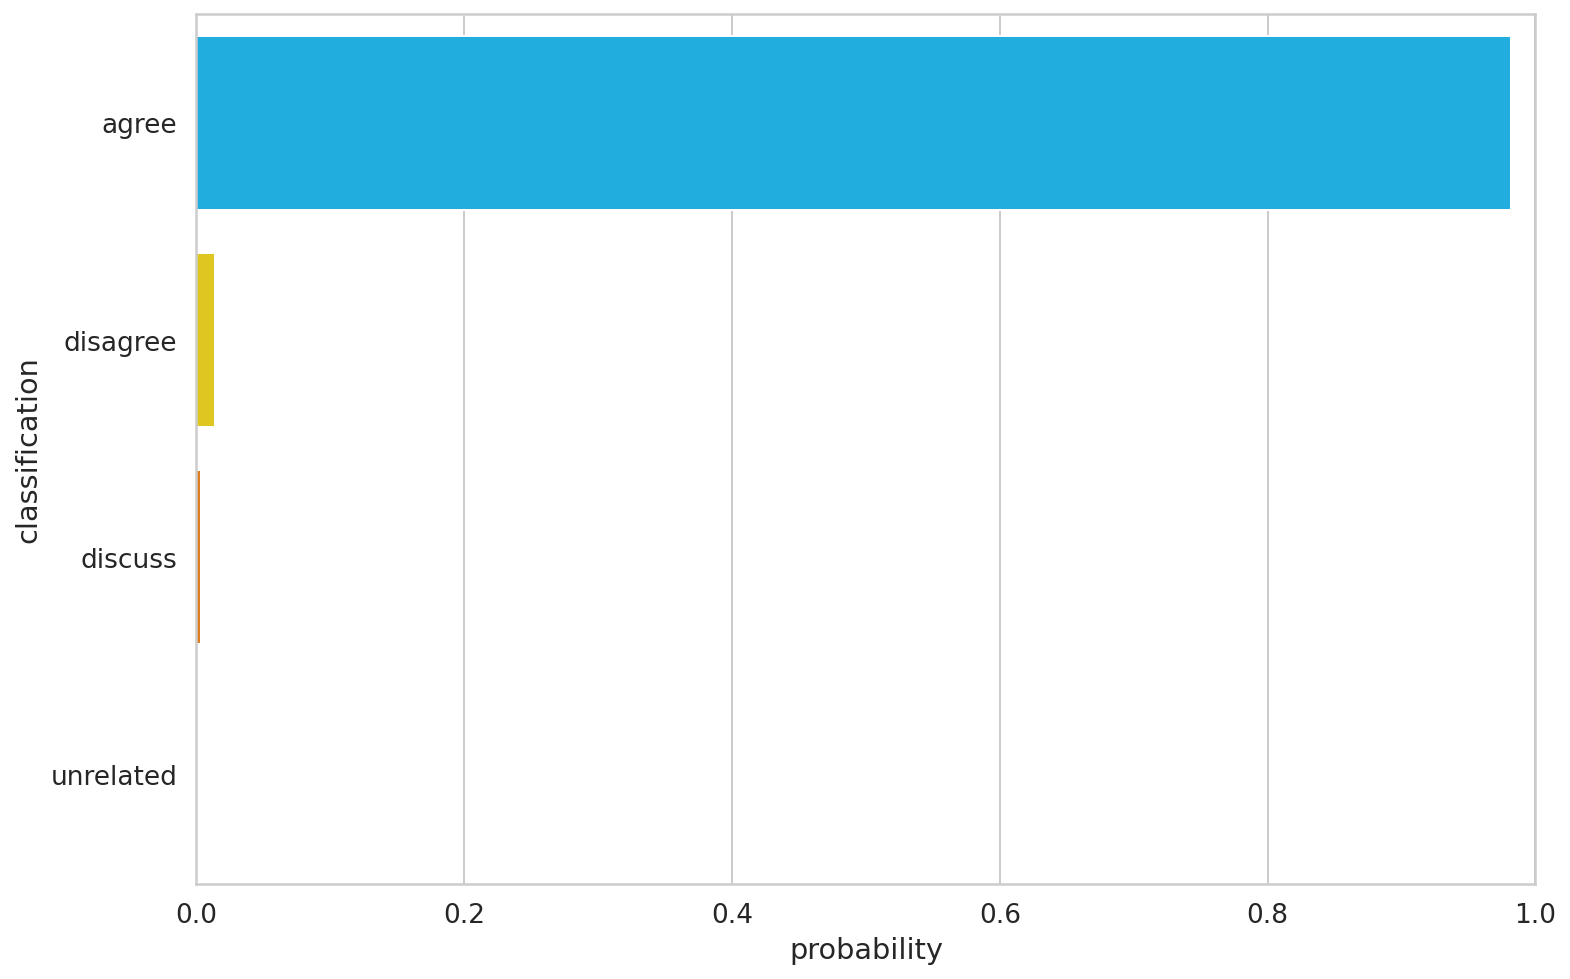

In [232]:
# Take a random instance of header and body text and see how it classifies
idx = 100

hb_text = y_hb_texts[idx]
true_class = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': stance_map.keys(),
  'values': y_pred_probs[idx]
})

print("\n".join(wrap(hb_text)))
print(f'True classification: {stance_map_inv.get(true_class.item())}')

sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('classification')
plt.xlabel('probability')
plt.xlim([0, 1]);